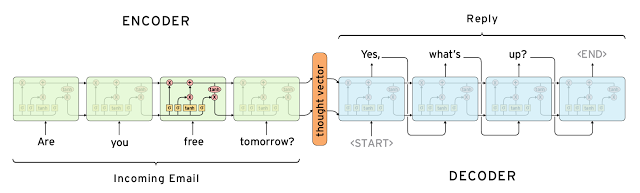

In [1]:
# Notebook Created by: Nazmi Asri
# Source: https://github.com/llSourcell/seq2seq_model_live/blob/master/2-seq2seq-advanced.ipynb

# I just created my own notebook, with additional notes that I can understand
# I believe retyping the code, understand it line by line is a great way how it actually work, in details
# and also, I updated the code so it works well for TensorFlow v1.1.0

from IPython.display import Image, display
Image("encoder-decoder.png")

In [2]:
# Import Dependencies
import numpy as np
import tensorflow as tf
import helpers
from tensorflow.contrib.rnn import LSTMCell, LSTMStateTuple

# Reset if have any previous graph
tf.reset_default_graph()

# Initialize Session
sess = tf.InteractiveSession()

In [3]:
# Check TensorFlow version
print("TensorFlow v" + tf.__version__)

TensorFlow v1.1.0


In [4]:
# Initialize our Padding (PAD) and End Of Sentence (EOS)
# This is to make our vector to have same length
PAD = 0
EOS = 1

# The word size
vocab_size = 10

# Embedding size, sentence size
input_embedding_size = 20

# Decoder Hidden Unit have twice size on encoder hidden unit
# This is because we want the output to be different
# Basically this is the num of neurons
encoder_hidden_units = 20
decoder_hidden_units = encoder_hidden_units * 2

# Initialize placeholder
encoder_inputs = tf.placeholder(shape=(None, None), dtype=tf.int32, name='encoder_inputs')
encoder_inputs_length = tf.placeholder(shape=(None, ), dtype=tf.int32, name='encoder_inputs_length')
decoder_targets = tf.placeholder(shape=(None, None), dtype=tf.int32, name='decoder_targets')

In [5]:
# Define the embeddings 
# We want to generate random uniform data, and the data should be in range interval of -1.0 and 1.0
embeddings = tf.Variable(tf.random_uniform([vocab_size, input_embedding_size], -1.0, 1.0), dtype=tf.float32)

# Input (encoder) to embeddings
encoder_inputs_embedded = tf.nn.embedding_lookup(embeddings, encoder_inputs)

In [6]:
# Define the encoder
# We initialize the LSTMCell with number of neurons
# Each of it are LSTM
encoder_cell = LSTMCell(encoder_hidden_units)
encoder_cell_backward = LSTMCell(encoder_hidden_units)

# Final Hidden State of the encoder 
((encoder_fw_outputs, encoder_bw_outputs), 
 (encoder_fw_final_state, encoder_bw_final_state)) = (
    tf.nn.bidirectional_dynamic_rnn(cell_fw=encoder_cell,
                                    cell_bw=encoder_cell_backward,
                                    inputs=encoder_inputs_embedded,
                                    sequence_length=encoder_inputs_length,
                                    dtype=tf.float32, 
                                    time_major=True))

In [7]:
# Encoder Forward Output
encoder_fw_outputs

<tf.Tensor 'bidirectional_rnn/fw/fw/TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 20) dtype=float32>

In [8]:
# Encoder Forward Final State
# h and c are commonly used to denote "output value" and "cell state"
encoder_fw_final_state

LSTMStateTuple(c=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_2:0' shape=(?, 20) dtype=float32>, h=<tf.Tensor 'bidirectional_rnn/fw/fw/while/Exit_3:0' shape=(?, 20) dtype=float32>)

In [9]:
# In this case we will not discard outputs, they would be used for attention.

# Get the encoder output (forward and backward) and concatenate it along
# Bidirectional RNN steps
encoder_outputs = tf.concat((encoder_fw_outputs, encoder_bw_outputs), 2)

# http://colah.github.io/posts/2015-08-Understanding-LSTMs/   
# Get the final cell state of the encoder by concatenate
# the encoder forward final state and backward
# h and c are commonly used to denote "output value" and "cell state"
# Those tensors represent combined internal state of the cell, and should be passed together
encoder_final_state_c = tf.concat(
    (encoder_fw_final_state.c, encoder_bw_final_state.c), 1)

encoder_final_state_h = tf.concat(
    (encoder_fw_final_state.h, encoder_bw_final_state.h), 1)

# TF Tuple used by LSTM Cells for state_size, zero_state, and output state
# This value of encoder final state will be used to feed the decoder
encoder_final_state = LSTMStateTuple(
    c=encoder_final_state_c,
    h=encoder_final_state_h
)

In [10]:
# Define the decoder
decoder_cell = LSTMCell(decoder_hidden_units)
decoder_cell_backward = LSTMCell(decoder_hidden_units)

# The encoder will be feed to the input in batches
encoder_max_time, batch_size = tf.unstack(tf.shape(encoder_inputs))

# Decoder length, +3 (make it a little bigger) because EOS token 
decoder_lengths = encoder_inputs_length + 3

In [11]:
# Output projection
# We don't have this is encoder, because it is built in but not in decoder
# Defining weight and biases
W = tf.Variable(tf.random_uniform([decoder_hidden_units, vocab_size], -1, 1), dtype=tf.float32)
b = tf.Variable(tf.zeros([vocab_size]), dtype=tf.float32)

In [12]:
# Check on the batch size
batch_size

<tf.Tensor 'unstack:1' shape=() dtype=int32>

In [13]:
# Padding and EOS Steps 

assert EOS == 1 and PAD == 0

# EOS value is 1, and PAD value is 0
eos_time_slice = tf.ones([batch_size], dtype=tf.int32, name='EOS')
pad_time_slice = tf.zeros([batch_size], dtype=tf.int32, name='PAD')

# Retrieves rows of the params tensor
# The behavior is similar to using indexing with arrays in numpy
# Adding the padding and EOS to the embeddings
eos_step_embedded = tf.nn.embedding_lookup(embeddings, eos_time_slice)
pad_step_embedded = tf.nn.embedding_lookup(embeddings, pad_time_slice)

In [14]:
# Here instead of using TensorFlow bidirectional function
# We manually do the loop function through time
# This is to get the initial cell state and input to RNN
# Usually we will use dynamic_rnn function for this, but for the sake 
#    of knowledge, lets do this

# This function done nothing except initialization of the values
def loop_fn_initial():
    
    # All False at the initial step
    initial_elements_finished = (0 >= decoder_lengths)  
    
    # EOS
    initial_input = eos_step_embedded
    
    # Last time steps cell state
    initial_cell_state = encoder_final_state
    
    # None
    initial_cell_output = None
    
    # None
    initial_loop_state = None  
    
    return (initial_elements_finished,
            initial_input,
            initial_cell_state,
            initial_cell_output,
            initial_loop_state)

In [15]:
#attention mechanism --choose which previously generated token to pass as input in the next timestep
def loop_fn_transition(time, previous_output, previous_state, previous_loop_state):

    
    def get_next_input():
        #dot product between previous ouput and weights, then + biases
        output_logits = tf.add(tf.matmul(previous_output, W), b)
        #Logits simply means that the function operates on the unscaled output of 
        #earlier layers and that the relative scale to understand the units is linear. 
        #It means, in particular, the sum of the inputs may not equal 1, that the values are not probabilities 
        #(you might have an input of 5).
        #prediction value at current time step
        
        #Returns the index with the largest value across axes of a tensor.
        # This is the attention
        prediction = tf.argmax(output_logits, axis=1)
        #embed prediction for the next input
        next_input = tf.nn.embedding_lookup(embeddings, prediction)
        return next_input
    
    
    elements_finished = (time >= decoder_lengths) # this operation produces boolean tensor of [batch_size]
                                                  # defining if corresponding sequence has ended

    
    
    #Computes the "logical and" of elements across dimensions of a tensor.
    finished = tf.reduce_all(elements_finished) # -> boolean scalar
    #Return either fn1() or fn2() based on the boolean predicate pred.
    input = tf.cond(finished, lambda: pad_step_embedded, get_next_input)
    
    #set previous to current
    state = previous_state
    output = previous_output
    loop_state = None

    return (elements_finished, 
            input,
            state,
            output,
            loop_state)

In [16]:
def loop_fn(time, previous_output, previous_state, previous_loop_state):
    if previous_state is None:    # time == 0
        assert previous_output is None and previous_state is None
        return loop_fn_initial()
    else:
        return loop_fn_transition(time, previous_output, previous_state, previous_loop_state)

#Creates an RNN specified by RNNCell cell and loop function loop_fn.
#This function is a more primitive version of dynamic_rnn that provides more direct access to the 
#inputs each iteration. It also provides more control over when to start and finish reading the sequence, 
#and what to emit for the output.
#ta = tensor array
decoder_outputs_ta, decoder_final_state, _ = tf.nn.raw_rnn(decoder_cell, loop_fn)
decoder_outputs = decoder_outputs_ta.stack()

In [17]:
decoder_outputs

<tf.Tensor 'TensorArrayStack/TensorArrayGatherV3:0' shape=(?, ?, 40) dtype=float32>

In [18]:
#to convert output to human readable prediction
#we will reshape output tensor

#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#reduces dimensionality
decoder_max_steps, decoder_batch_size, decoder_dim = tf.unstack(tf.shape(decoder_outputs))
#flettened output tensor
decoder_outputs_flat = tf.reshape(decoder_outputs, (-1, decoder_dim))
#pass flattened tensor through decoder
decoder_logits_flat = tf.add(tf.matmul(decoder_outputs_flat, W), b)
#prediction vals
decoder_logits = tf.reshape(decoder_logits_flat, (decoder_max_steps, decoder_batch_size, vocab_size))

In [19]:
#final prediction
decoder_prediction = tf.argmax(decoder_logits, 2)

In [20]:
#cross entropy loss
#one hot encode the target values so we don't rank just differentiate
stepwise_cross_entropy = tf.nn.softmax_cross_entropy_with_logits(
    labels=tf.one_hot(decoder_targets, depth=vocab_size, dtype=tf.float32),
    logits=decoder_logits,
)

#loss function
loss = tf.reduce_mean(stepwise_cross_entropy)
#train it 
train_op = tf.train.AdamOptimizer().minimize(loss)

In [21]:

sess.run(tf.global_variables_initializer())

In [22]:
batch_size = 100
batches = helpers.random_sequences(length_from=3, length_to=8,
                                   vocab_lower=2, vocab_upper=10,
                                   batch_size=batch_size)

print('head of the batch:')
for seq in next(batches)[:10]:
    print(seq)

head of the batch:
[8, 3, 9, 5, 8]
[4, 2, 9, 7, 5, 8, 9, 2]
[4, 3, 7, 3]
[2, 4, 8]
[4, 4, 3, 9]
[3, 5, 3, 6, 3, 4, 6, 5]
[4, 7, 5]
[8, 2, 8]
[3, 2, 4, 9, 6, 8, 8]
[8, 3, 4, 3, 4, 8, 4]


In [23]:
def next_feed():
    batch = next(batches)
    encoder_inputs_, encoder_input_lengths_ = helpers.batch(batch)
    decoder_targets_, _ = helpers.batch(
        [(sequence) + [EOS] + [PAD] * 2 for sequence in batch]
    )
    return {
        encoder_inputs: encoder_inputs_,
        encoder_inputs_length: encoder_input_lengths_,
        decoder_targets: decoder_targets_,
    }

In [24]:
loss_track = []

In [25]:
max_batches = 5001
batches_in_epoch = 1000

try:
    for batch in range(max_batches):
        fd = next_feed()
        _, l = sess.run([train_op, loss], fd)
        loss_track.append(l)

        if batch == 0 or batch % batches_in_epoch == 0:
            print('batch {}'.format(batch))
            print('  minibatch loss: {}'.format(sess.run(loss, fd)))
            predict_ = sess.run(decoder_prediction, fd)
            for i, (inp, pred) in enumerate(zip(fd[encoder_inputs].T, predict_.T)):
                print('  sample {}:'.format(i + 1))
                print('    input     > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                if i >= 2:
                    break
            print()

except KeyboardInterrupt:
    print('training interrupted')

batch 0
  minibatch loss: 2.3659873008728027
  sample 1:
    input     > [9 6 8 0 0 0 0 0]
    predicted > [3 3 3 4 3 6 0 0 0 0 0]
  sample 2:
    input     > [2 2 2 2 8 0 0 0]
    predicted > [3 3 4 6 6 4 6 6 0 0 0]
  sample 3:
    input     > [7 7 5 7 4 4 9 3]
    predicted > [3 3 3 3 4 3 4 6 6 4 6]

batch 1000
  minibatch loss: 0.482132226228714
  sample 1:
    input     > [3 9 5 4 0 0 0 0]
    predicted > [3 9 5 4 1 0 0 0 0 0 0]
  sample 2:
    input     > [6 7 2 0 0 0 0 0]
    predicted > [6 7 2 1 0 0 0 0 0 0 0]
  sample 3:
    input     > [5 9 2 2 4 7 0 0]
    predicted > [5 9 2 2 4 7 1 0 0 0 0]

batch 2000
  minibatch loss: 0.18426550924777985
  sample 1:
    input     > [2 9 9 9 5 8 5 5]
    predicted > [2 9 9 9 5 8 5 5 1 0 0]
  sample 2:
    input     > [6 9 3 9 7 2 6 8]
    predicted > [6 9 9 6 7 2 8 8 1 0 0]
  sample 3:
    input     > [5 7 4 2 6 2 6 2]
    predicted > [5 7 4 2 2 6 6 2 1 0 0]

batch 3000
  minibatch loss: 0.07580249756574631
  sample 1:
    input     > [5 3 

loss 0.0407 after 500100 examples (batch_size=100)


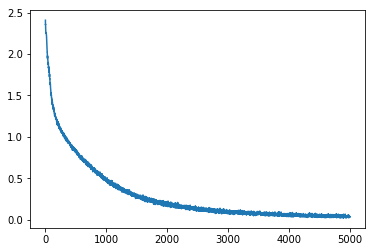

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(loss_track)
print('loss {:.4f} after {} examples (batch_size={})'.format(loss_track[-1], len(loss_track)*batch_size, batch_size))